In [1]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_val_score, train_test_split

from sklearn import metrics, preprocessing

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
# сразу напишем код функции, которая будет вычислять все нужные метрики

def Reg_Models_Evaluation_Metrics (model,X_train,y_train,X_test,y_test,y_pred):
    cv_score = cross_val_score(estimator = model, X = X_train, y = y_train, cv = 10)

    # Calculating Adjusted R-squared
    r2 = model.score(X_test, y_test)
    # Number of observations is the shape along axis 0
    n = X_test.shape[0]
    # Number of features (predictors, p) is the shape along axis 1
    p = X_test.shape[1]
    # Adjusted R-squared formula
    adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
    RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    R2 = model.score(X_test, y_test)
    CV_R2 = cv_score.mean()

    print(f'RMSE:  {round(RMSE,4)}\n  R2: {round(R2,4)}\n Adjusted R2: {round(adjusted_r2, 4)}\n Cross Validated R2: {round(cv_score.mean(),4)}')
    return R2, adjusted_r2, CV_R2, RMSE

# Регрессия

In [3]:
from google.colab import drive

drive.mount('/content/drive/')

df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/CarPrice_Assignment.csv")

Mounted at /content/drive/


## Разведочный анализ и предобработка данных

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   car_ID            205 non-null    int64  
 1   symboling         205 non-null    int64  
 2   CarName           205 non-null    object 
 3   fueltype          205 non-null    object 
 4   aspiration        205 non-null    object 
 5   doornumber        205 non-null    object 
 6   carbody           205 non-null    object 
 7   drivewheel        205 non-null    object 
 8   enginelocation    205 non-null    object 
 9   wheelbase         205 non-null    float64
 10  carlength         205 non-null    float64
 11  carwidth          205 non-null    float64
 12  carheight         205 non-null    float64
 13  curbweight        205 non-null    int64  
 14  enginetype        205 non-null    object 
 15  cylindernumber    205 non-null    object 
 16  enginesize        205 non-null    int64  
 1

In [5]:
def obj_in_int(df):
  for column in df:
    if df[column].dtype == 'O':
      df[column] = df[column].replace(list(df[column].unique()), list(range(len(list(df[column].unique())))))

In [6]:
obj_in_int(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   car_ID            205 non-null    int64  
 1   symboling         205 non-null    int64  
 2   CarName           205 non-null    int64  
 3   fueltype          205 non-null    int64  
 4   aspiration        205 non-null    int64  
 5   doornumber        205 non-null    int64  
 6   carbody           205 non-null    int64  
 7   drivewheel        205 non-null    int64  
 8   enginelocation    205 non-null    int64  
 9   wheelbase         205 non-null    float64
 10  carlength         205 non-null    float64
 11  carwidth          205 non-null    float64
 12  carheight         205 non-null    float64
 13  curbweight        205 non-null    int64  
 14  enginetype        205 non-null    int64  
 15  cylindernumber    205 non-null    int64  
 16  enginesize        205 non-null    int64  
 1

In [7]:
df.symboling = df.symboling + 2
df.describe()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
count,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.00000,205.000000,205.000000,205.000000,...,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000
mean,103.000000,2.834146,76.448780,0.097561,0.180488,0.560976,1.80000,0.673171,0.014634,98.756585,...,126.907317,1.478049,3.329756,3.255415,10.142537,104.117073,5125.121951,25.219512,30.751220,13276.710571
std,59.322565,1.245307,41.346261,0.297446,0.385535,0.497483,0.83666,0.556171,0.120377,6.021776,...,41.642693,2.184113,0.270844,0.313597,3.972040,39.544167,476.985643,6.542142,6.886443,7988.852332
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,86.600000,...,61.000000,0.000000,2.540000,2.070000,7.000000,48.000000,4150.000000,13.000000,16.000000,5118.000000
25%,52.000000,2.000000,43.000000,0.000000,0.000000,0.000000,1.00000,0.000000,0.000000,94.500000,...,97.000000,0.000000,3.150000,3.110000,8.600000,70.000000,4800.000000,19.000000,25.000000,7788.000000
50%,103.000000,3.000000,79.000000,0.000000,0.000000,1.000000,2.00000,1.000000,0.000000,97.000000,...,120.000000,1.000000,3.310000,3.290000,9.000000,95.000000,5200.000000,24.000000,30.000000,10295.000000
75%,154.000000,4.000000,113.000000,0.000000,0.000000,1.000000,2.00000,1.000000,0.000000,102.400000,...,141.000000,1.000000,3.580000,3.410000,9.400000,116.000000,5500.000000,30.000000,34.000000,16503.000000
max,205.000000,5.000000,146.000000,1.000000,1.000000,1.000000,4.00000,2.000000,1.000000,120.900000,...,326.000000,7.000000,3.940000,4.170000,23.000000,288.000000,6600.000000,49.000000,54.000000,45400.000000


In [8]:
scaler_df = df.copy()

for column in df.columns:
  scaler_df[column] = (scaler_df[column] - scaler_df[column].min()) / (scaler_df[column].max() - scaler_df[column].min())

scaler_df.describe()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
count,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,...,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000
mean,0.500000,0.566829,0.523622,0.097561,0.180488,0.560976,0.450000,0.336585,0.014634,0.354419,...,0.248707,0.211150,0.564111,0.564483,0.196409,0.233821,0.398009,0.339431,0.388190,0.202540
std,0.290797,0.249061,0.283194,0.297446,0.385535,0.497483,0.209165,0.278085,0.120377,0.175562,...,0.157142,0.312016,0.193460,0.149332,0.248253,0.164767,0.194688,0.181726,0.181222,0.198323
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.250000,0.400000,0.294521,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.230321,...,0.135849,0.000000,0.435714,0.495238,0.100000,0.091667,0.265306,0.166667,0.236842,0.066283
50%,0.500000,0.600000,0.541096,0.000000,0.000000,1.000000,0.500000,0.500000,0.000000,0.303207,...,0.222642,0.142857,0.550000,0.580952,0.125000,0.195833,0.428571,0.305556,0.368421,0.128519
75%,0.750000,0.800000,0.773973,0.000000,0.000000,1.000000,0.500000,0.500000,0.000000,0.460641,...,0.301887,0.142857,0.742857,0.638095,0.150000,0.283333,0.551020,0.472222,0.473684,0.282632
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Модели регрессии

In [15]:
X = scaler_df.drop(['price'], axis=1)
y = scaler_df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=15)

### Линейная регрессия

In [16]:
from sklearn.linear_model import LinearRegression

# Create a linear regression model
modelLR = LinearRegression()

# Fit the model to the data
modelLR.fit(X_train, y_train)

# Predict the response for a new data point
y_pr_LR = modelLR.predict(X_test)

_ = Reg_Models_Evaluation_Metrics(modelLR, X_train, y_train, X_test, y_test, y_pr_LR)

RMSE:  0.0641
  R2: 0.9018
 Adjusted R2: 0.8335
 Cross Validated R2: 0.7997


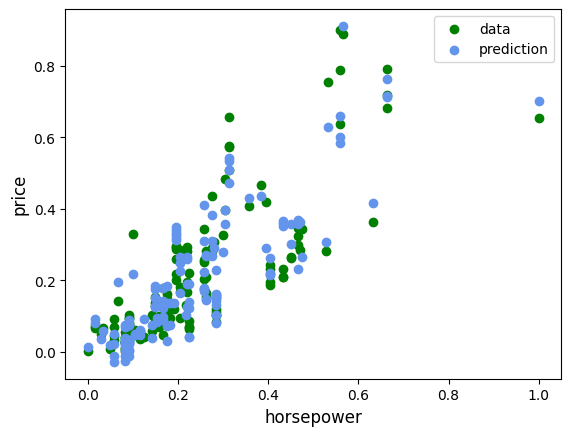

In [17]:
plt.scatter(X_train["horsepower"], y_train, color='g', label='data')
plt.scatter(X_train["horsepower"], modelLR.predict(X_train), color='cornflowerblue', label='prediction')
plt.ylabel('price', size=12)
plt.xlabel('horsepower', size=12)
plt.legend()
plt.show()

### Полиномиальная регрессия

In [23]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=5)

poly_features = poly.fit_transform(X)
X_p_train, X_p_test, y_p_train, y_p_test = train_test_split(poly_features, y, test_size=0.3, random_state=15)

# Create a linear regression model
modelPR = LinearRegression()

# Fit the model to the data
modelPR.fit(X_p_train, y_p_train)

# Predict the response for a new data point
y_pr_PR = modelPR.predict(X_p_test)

_ = Reg_Models_Evaluation_Metrics(modelPR, X_p_train, y_p_train, X_p_test, y_p_test, y_pr_PR)

RMSE:  0.5294
  R2: -5.6947
 Adjusted R2: 1.0029
 Cross Validated R2: -16.7436


Метрики плохии, модель не подходит для прогнозирования

### Регрессия дерева принятия решений

In [24]:
from sklearn.tree import DecisionTreeRegressor

# Create a stepwise regression model
modelDT = DecisionTreeRegressor()

# Fit the model to the data
modelDT.fit(X_train, y_train)

# Predict the response for a new data point
y_dt_pred = modelDT.predict(X_test)

_ = Reg_Models_Evaluation_Metrics(modelDT, X_train, y_train, X_test, y_test, y_dt_pred)

RMSE:  0.0632
  R2: 0.9047
 Adjusted R2: 0.8385
 Cross Validated R2: 0.7981


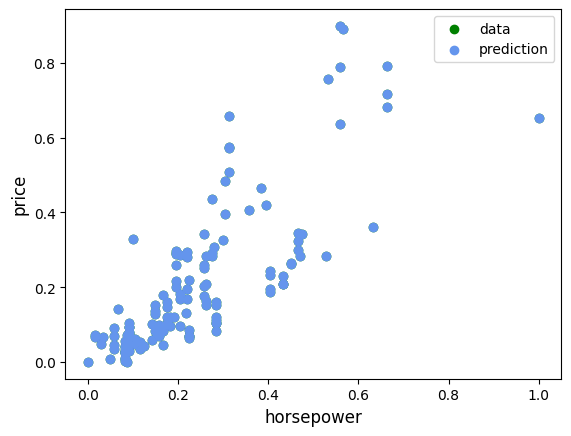

In [25]:
plt.scatter(X_train["horsepower"], y_train, color='g', label='data')
plt.scatter(X_train["horsepower"], modelDT.predict(X_train), color='cornflowerblue', label='prediction')
plt.ylabel('price', size=12)
plt.xlabel('horsepower', size=12)
plt.legend()
plt.show()

### Регрессия случайного леса

In [26]:
from sklearn.ensemble import RandomForestRegressor

# Create a stepwise regression model
modelRF = RandomForestRegressor(n_estimators=100)

# Fit the model to the data
modelRF.fit(X_train, y_train)

# Predict the response for a new data point
y_rf_pred = modelRF.predict(X_test)


_ = Reg_Models_Evaluation_Metrics(modelRF, X_train, y_train, X_test, y_test, y_rf_pred)

RMSE:  0.0475
  R2: 0.9462
 Adjusted R2: 0.9088
 Cross Validated R2: 0.8829


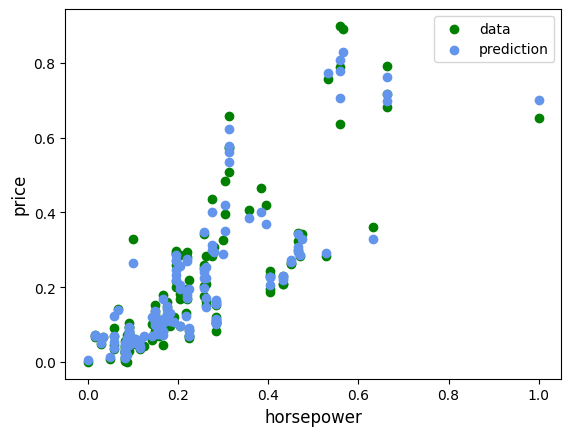

In [27]:
plt.scatter(X_train["horsepower"], y_train, color='g', label='data')
plt.scatter(X_train["horsepower"], modelRF.predict(X_train), color='cornflowerblue', label='prediction')
plt.ylabel('price', size=12)
plt.xlabel('horsepower', size=12)
plt.legend()
plt.show()

### Регрессия опорных векторов (SVR)

In [29]:
from sklearn.svm import SVR

#### Линейное ядро

In [28]:
# Create a support vector regression model
modelSVR_L = SVR(kernel='linear')

modelSVR_L.fit(X_train, y_train)

# Predict the response for a new data point
y_rf_pred = modelSVR_L.predict(X_test)


_ = Reg_Models_Evaluation_Metrics(modelSVR_L, X_train, y_train, X_test, y_test, y_rf_pred)

RMSE:  0.0687
  R2: 0.8873
 Adjusted R2: 0.809
 Cross Validated R2: 0.7445


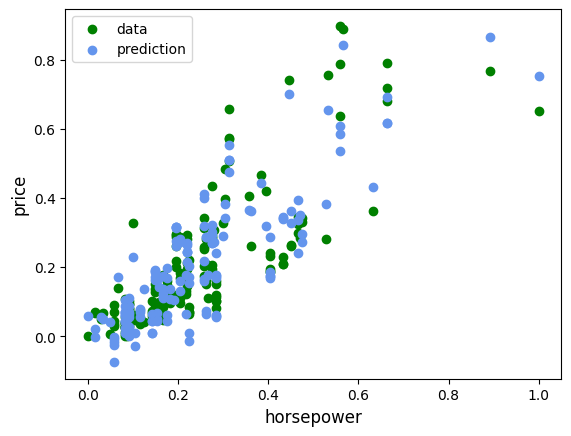

In [ ]:
plt.scatter(X_train["horsepower"], y_train, color='g', label='data')
plt.scatter(X_train["horsepower"], modelSVR_L.predict(X_train), color='cornflowerblue', label='prediction')
plt.ylabel('price', size=12)
plt.xlabel('horsepower', size=12)
plt.legend()
plt.show()

#### Полиномиальное ядро

In [30]:
modelSVR_P = SVR(kernel='poly')

modelSVR_P.fit(X_train, y_train)

# Predict the response for a new data point
y_rf_pred = modelSVR_P.predict(X_test)


_ = Reg_Models_Evaluation_Metrics(modelSVR_P, X_train, y_train, X_test, y_test, y_rf_pred)

RMSE:  0.0728
  R2: 0.8733
 Adjusted R2: 0.7853
 Cross Validated R2: 0.722


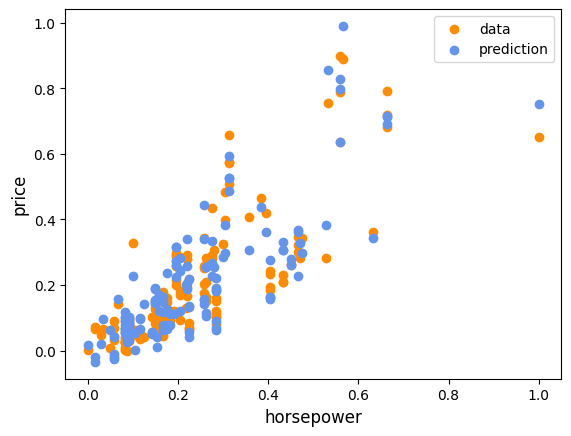

In [31]:
plt.scatter(X_train["horsepower"], y_train, color='darkorange',
            label='data')
plt.scatter(X_train["horsepower"], modelSVR_P.predict(X_train), color='cornflowerblue',
         label='prediction')
plt.ylabel('price', size=12)
plt.xlabel('horsepower', size=12)
plt.legend()
plt.show()

#### Ядро радиальной базисной функции

In [ ]:
modelSVR_R = SVR(kernel='rbf')

modelSVR_R.fit(X_train, y_train)

# Predict the response for a new data point
y_rf_pred = modelSVR_R.predict(X_test)


_ = Reg_Models_Evaluation_Metrics(modelSVR_R, X_train, y_train, X_test, y_test, y_rf_pred)

RMSE:  0.0715
  R2: 0.8811
 Adjusted R2: 0.6829
 Cross Validated R2: 0.7849


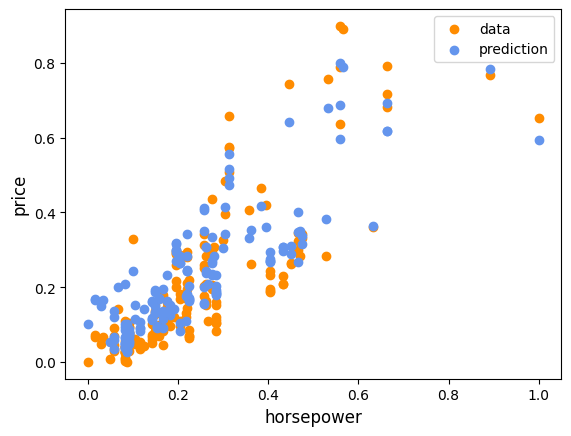

In [ ]:
plt.scatter(X_train["horsepower"], y_train, color='darkorange',
            label='data')
plt.scatter(X_train["horsepower"], modelSVR_R.predict(X_train), color='cornflowerblue',
         label='prediction')
plt.ylabel('price', size=12)
plt.xlabel('horsepower', size=12)
plt.legend()
plt.show()

### Регрессия ElasticNet

In [33]:
from sklearn.linear_model import ElasticNet

#### Частный случай. Регрессия Риджа



In [73]:
# Create an elastic net regression model
modelEN = ElasticNet(alpha=0.0, l1_ratio=0.0)

# Fit the model to the data
modelEN.fit(X_train, y_train)

# Predict the response for a new data point
y_en_pred = modelEN.predict(X_test)

_ = Reg_Models_Evaluation_Metrics(modelEN, X_train, y_train, X_test, y_test, y_en_pred)

RMSE:  0.0641
  R2: 0.902
 Adjusted R2: 0.8339
 Cross Validated R2: 0.7999


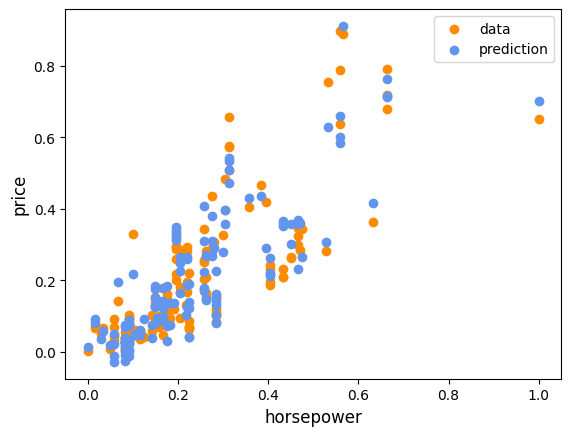

In [74]:
plt.scatter(X_train["horsepower"], y_train, color='darkorange',
            label='data')
plt.scatter(X_train["horsepower"], modelEN.predict(X_train), color='cornflowerblue',
         label='prediction')
plt.ylabel('price', size=12)
plt.xlabel('horsepower', size=12)
plt.legend()
plt.show()

#### Частный случай. Регрессия Лассо

In [54]:
# Create an elastic net regression model
modelEN = ElasticNet(alpha=0.01, l1_ratio=1.0)

# Fit the model to the data
modelEN.fit(X_train, y_train)

# Predict the response for a new data point
y_en_pred = modelEN.predict(X_test)

_ = Reg_Models_Evaluation_Metrics(modelEN, X_train, y_train, X_test, y_test, y_en_pred)

RMSE:  0.1093
  R2: 0.7149
 Adjusted R2: 0.5169
 Cross Validated R2: 0.5975


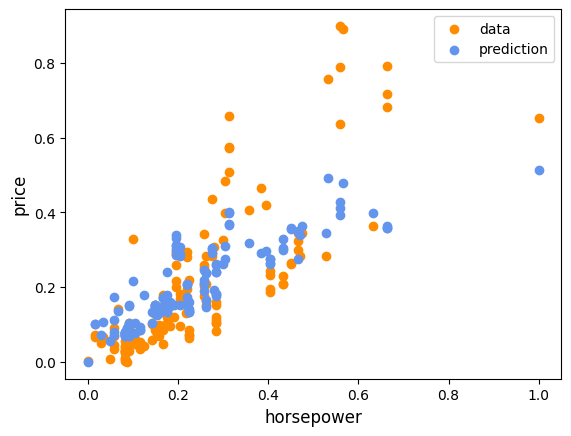

In [55]:
plt.scatter(X_train["horsepower"], y_train, color='darkorange',
            label='data')
plt.scatter(X_train["horsepower"], modelEN.predict(X_train), color='cornflowerblue',
         label='prediction')
plt.ylabel('price', size=12)
plt.xlabel('horsepower', size=12)
plt.legend()
plt.show()

#### Общий случай

In [71]:
# Create an elastic net regression model
modelEN = ElasticNet(alpha=0.01, l1_ratio=0.5)

# Fit the model to the data
modelEN.fit(X_train, y_train)

# Predict the response for a new data point
y_en_pred = modelEN.predict(X_test)

_ = Reg_Models_Evaluation_Metrics(modelEN, X_train, y_train, X_test, y_test, y_en_pred)

RMSE:  0.0759
  R2: 0.8622
 Adjusted R2: 0.7666
 Cross Validated R2: 0.691


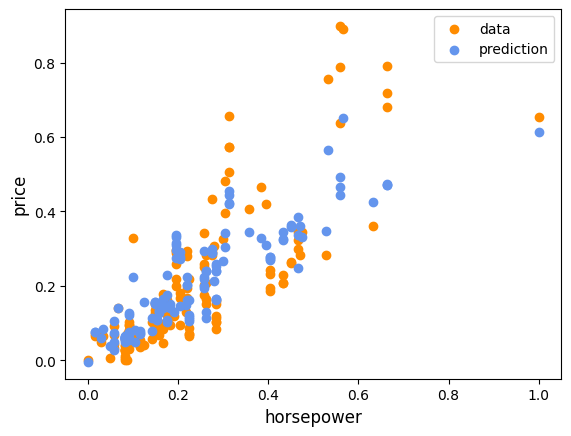

In [72]:
plt.scatter(X_train["horsepower"], y_train, color='darkorange',
            label='data')
plt.scatter(X_train["horsepower"], modelEN.predict(X_train), color='cornflowerblue',
         label='prediction')
plt.ylabel('price', size=12)
plt.xlabel('horsepower', size=12)
plt.legend()
plt.show()